In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import signal
import scipy.signal as sg
from tqdm import tqdm
import os

from obspy.signal.filter import bandpass, lowpass, highpass

from hyperopt import hp, tpe, Trials, fmin
from librosa import power_to_db
import scipy.fftpack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection._search import ParameterGrid
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,Ridge

import xgboost as xgb
import catboost as cb
from scipy.signal import welch

import tsfresh
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import feature_calculators

import eli5
from eli5.sklearn import PermutationImportance

import datetime

In [2]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [3]:
df = pd.read_csv('../data/train.csv', dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32})

In [4]:
np.where(df['time_to_failure'].diff()>0)[0]

array([  5656574,  50085878, 104677356, 138772453, 187641820, 218652630,
       245829585, 307838917, 338276287, 375377848, 419368880, 461811623,
       495800225, 528777115, 585568144, 621985673])

In [5]:
st_idx = np.array([0,  5656574,  50085878, 104677356, 138772453, 187641820, 218652630,
       245829585, 307838917, 338276287, 375377848, 419368880, 461811623,
       495800225, 528777115, 585568144, 621985673])

In [6]:
end_idx = np.array([5656574,  50085878, 104677356, 138772453, 187641820, 218652630,
       245829585, 307838917, 338276287, 375377848, 419368880, 461811623,
       495800225, 528777115, 585568144, 621985673, 629145480])-1

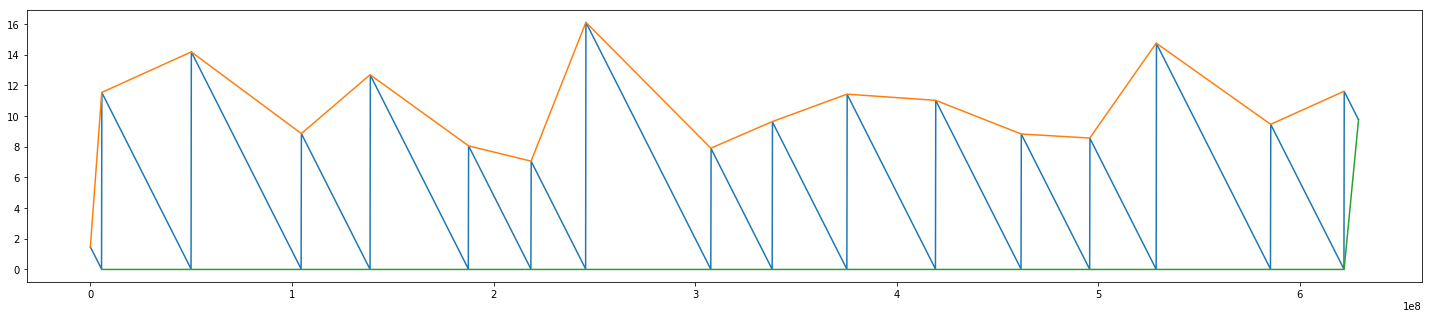

In [7]:
plt.figure(figsize=(25,5))
sns.lineplot(x=np.arange(df.shape[0])[::150000], y=df['time_to_failure'].values[::150000])
sns.lineplot(x=st_idx, y=df['time_to_failure'].values[st_idx])
sns.lineplot(x=end_idx, y=df['time_to_failure'].values[end_idx])

In [8]:
x= df.acoustic_data.values[:150000]
sr = 4000000
n_fft = 4096
hop_length = 1024
n_mels = 16

In [34]:
mfcc, mfcc_delta, mfcc_accelerate = Spectrum.mfcc(x, sr, n_fft, hop_length, n_mels)
mfcc.shape,mfcc_delta.shape, mfcc_accelerate.shape

/home/ubuntu/anaconda3/envs/tensorflow_gpu_p36/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


((16, 147), (16, 147), (16, 147))

In [51]:
mfcc[0,:].shape

(147,)

In [35]:
logmel, logmel_delta, logmel_accelerate = Spectrum.logmel(x, sr, n_fft, hop_length, n_mels)
logmel.shape,logmel_delta.shape, logmel_accelerate.shape

((16, 147), (16, 147), (16, 147))

In [37]:
stft = Spectrum.stft(x, n_fft, hop_length)
stft.shape

(2049, 147)

In [39]:
tempogram = Spectrum.tempogram(x, sr, hop_length, n_mels)
tempogram.shape

/home/ubuntu/anaconda3/envs/tensorflow_gpu_p36/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


(384, 147)

In [46]:
flac0,flac1,flac2,flac3,flac4 = Spectrum.flac(x, sr, n_fft, hop_length, n_mels)
flac0.shape,flac1.shape,flac2.shape,flac3.shape,flac4.shape

((15, 146), (15, 146), (15, 146), (15, 146), (15, 146))

In [9]:
class Spectrum:

    def mfcc(y, sr, n_fft, hop_length, n_mels, **kwargs):
        mfcc = librosa.feature.mfcc(y=y, sr=sr, S=None, n_mfcc=n_mels, n_fft=n_fft, hop_length=hop_length, **kwargs)
        delta = librosa.feature.delta(mfcc)
        accelerate = librosa.feature.delta(mfcc, order=2)
        return mfcc, delta, accelerate

    def logmel(y, sr, n_fft, hop_length, n_mels, **kwargs):
        melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, **kwargs)
        logmel = librosa.core.power_to_db(melspec) 
        delta = librosa.feature.delta(logmel)
        accelerate = librosa.feature.delta(logmel, order=2)
        return logmel, delta, accelerate

    def stft(y, n_fft, hop_length, **kwargs):
        stft = librosa.core.stft(y=y, n_fft=n_fft, hop_length=hop_length, **kwargs)
        return np.abs(stft)
    
    def tempogram(y, sr, hop_length, n_mels, **kwargs):
        oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length, **kwargs)
        tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length, **kwargs)
        return tempogram
    
    def flac(x, sr, n_fft, hop_length, n_mels, filter_format=[0,1,2,3,4], **kwargs):
        stft = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
        if n_mels==None:
            S = stft
        else:
            mel_basis = librosa.filters.mel(sr, n_fft, n_mels =n_mels)
            S = np.dot(mel_basis,stft)
        return [librosa.power_to_db(np.abs(Spectrum._flac(S, i))**2) for i in filter_format]
    
    def _flac(S, filter_format):
    
        """
        desciption
        ----------
        flac(Fourier Local Auto-Correlations) formula

        filter 0  [[0,0],[0,0]]
        2|0
        0|0
        filter 1 [[0,0],[0,1]]
        1|1
        0|0
        filter 2 [[0,0],[1,0]]
        1|0
        1|0
        filter 3 [[0,0],[1,1]]
        1|0
        0|1
        filter 4 [[0,1],[1,0]]
        0|1
        1|0

        Parameters
        ----------
        S: array-like
            stft or melspect

        Returns
        -------
        S: 2d-array_like complex values
            flac features
        """

        if filter_format== 0:
            filter_format = [[0,0],[0,0]]
        elif filter_format== 1:
            filter_format = [[0,0],[0,1]]
        elif filter_format== 2:
            filter_format = [[0,0],[1,0]]
        elif filter_format== 3:
            filter_format = [[0,0],[1,1]]
        elif filter_format== 4:
            filter_format = [[0,1],[1,0]]
        filter_size = 2


        # define flac_features shape for 1 filter
        flac_features = np.zeros((S.shape[0]-filter_size+1, S.shape[1]-filter_size+1), dtype=complex)
        for row_start in np.arange(0, S.shape[0]-filter_size+1, 1):
            for col_start in np.arange(0, S.shape[1]-filter_size+1, 1):

                # extrac the block from pectrogram
                block = S[row_start:row_start+filter_size,col_start:col_start+filter_size]

                # get the point r complex value
                r = block[filter_format[0][0],filter_format[0][1]]

                # get the point r+alpha complex value
                r_alphas = [block[filter_format[i][0],filter_format[i][1]] for i in np.arange(1,len(filter_format),1)]

                # caculate the complex conjugate of point r
                conjugate_r = np.conj(r)

                # caculate the magnitudes of point r (A)
                amplitude_A = np.sqrt(conjugate_r.real ** 2 + conjugate_r.imag ** 2)

                # caculate the phase of point r (theta)
                phases_A = np.arctan2(-conjugate_r.imag, conjugate_r.real)

                amplitude_B_list = []
                phases_B_list =[]
                for r_alpha in r_alphas:
                    # caculate the magnitudes of point r+alpha (B)
                    amplitude_B = np.sqrt(r_alpha.real ** 2 + r_alpha.imag ** 2)
                    # caculate the phase of point r+alpha (phi)
                    phases_B = np.arctan2(-r_alpha.imag, r_alpha.real)
                    amplitude_B_list.append(amplitude_B)
                    phases_B_list.append(phases_B)

                # caculate flac feature of point r
                flac_feature_ = amplitude_A*np.prod(amplitude_B_list)*np.exp(complex(0,np.sum(phases_B_list)+phases_A))
                flac_features[row_start][col_start] = flac_feature_

        return flac_features
    

In [10]:
class StatsFC:

    def rms(x):
        return np.sqrt(np.mean(np.power(x, 2)))

    def rssq(x):
        return np.sum(np.power(x, 2))

    def crest_factor(x):
        if np.sqrt(np.mean(x ** 2)) == 0:
            return -9999
        else:
            return abs(max(x, key=abs)) / (np.sqrt(np.mean(x ** 2)))

    def peak_peak_amp(x):
        return abs(max(x, key=abs)) - abs(min(x, key=abs))

    # if denominator is zero, return NaN
    def clearance_factor(x):
        if np.mean(np.sqrt(abs(x))) ** 2 == 0:
            return -9999
        else:
            return abs(max(x, key=abs)) / (np.mean(np.sqrt(abs(x))) ** 2)

    def impluse_indicator(x):
        if np.mean(abs(x)) == 0:
            return -9999
        else:
            return abs(max(x, key=abs)) / (np.mean(abs(x)))

    def impulse_factor(x):
        if np.sum(np.abs(x)) == 0:
            return -9999
        else:
            return StatsFC.peak_peak_amp(x) / 2 / (np.sum(np.abs(x)) / len(x))
        
    def variance(x):
        return np.var(x)
    
    # 3rd moment
    def skewness(x):
        return scipy.stats.skew(x)

    def kurtosis(x):
        return scipy.stats.kurtosis(x)

    def mean(x):
        return np.mean(x)

    def median(x):
        return np.median(x)

    def max(x):
        return np.max(x)

    def min(x):
        return np.min(x)

    def std(x):
        return np.std(x)
    
    def quantile99(x):
        return np.quantile(x, 0.99)

    def quantile95(x):
        return np.quantile(x, 0.95)

    def quantile75(x):
        return np.quantile(x, 0.75)

    def quantile25(x):
        return np.quantile(x, 0.25)

    def quantile05(x):
        return np.quantile(x, 0.05)

    def quantile01(x):
        return np.quantile(x, 0.01)
    
    def entropy(x):
        return scipy.stats.entropy(np.abs(x))

    def form_factor(x):
        if np.mean(np.abs(x)) == 0:
            return -9999
        else:
            return rms(x) / np.mean(np.abs(x))

    def no_zero_crossing(x):
        return (np.diff(np.sign(x)) != 0).sum()

    def peak_to_average_power_ratio(x):
        return np.power(crest_factor(x), 2)

    def smoothness(x):
        return 1 - 1 / (1 + np.power(std(x), 2))

In [11]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

CUTOFF = 18000
NY_FREQ_IDX = 75000
MAX_FREQ_IDX = 20000
FREQ_STEP = 2500
def des_bw_filter_lp(cutoff=CUTOFF):  # low pass filter
    b, a = sg.butter(4, Wn=cutoff/NY_FREQ_IDX)
    return b, a

def des_bw_filter_hp(cutoff=CUTOFF):  # high pass filter
    b, a = sg.butter(4, Wn=cutoff/NY_FREQ_IDX, btype='highpass')
    return b, a

def des_bw_filter_bp(low, high):  # band pass filter
    b, a = sg.butter(4, Wn=(low/NY_FREQ_IDX, high/NY_FREQ_IDX), btype='bandpass')
    return b, a

In [12]:
def extract_spectrum_features(x):
    
    df_features = pd.DataFrame()
    segment = 0
    
#     x= df.acoustic_data.values[:150000]
    sr = 4000000
    n_fft = 4096
    hop_length = 1024
    n_mels = 16

    mfcc, mfcc_delta, mfcc_accelerate = Spectrum.mfcc(x, sr, n_fft, hop_length, n_mels)
#     logmel, logmel_delta, logmel_accelerate = Spectrum.logmel(x, sr, n_fft, hop_length, n_mels)
    tempogram = Spectrum.tempogram(x, sr, hop_length, n_mels)
    flac_list = Spectrum.flac(x, sr, n_fft, hop_length, n_mels, filter_format=[3])
    flac3 = flac_list[0]
    
    spec_list = [mfcc, mfcc_delta, mfcc_accelerate, tempogram,flac3]
    spec_name_list = ['mfcc', 'mfcc_delta', 'mfcc_accelerate', 'tempogram', 'flac3']
    
    for spec, spec_name in zip(spec_list, spec_name_list):
        for i in np.arange(spec.shape[0]):
            spec_i = spec[i]
            spec_i_series = pd.Series(spec[i])
            
#             df_features.loc[segment, '{}_{}_rms'.format(spec_name,i)] = StatsFC.rms(spec_i)
#             df_features.loc[segment, '{}_{}_rssq'.format(spec_name,i)] = StatsFC.rssq(spec_i)
#             df_features.loc[segment, '{}_{}_crest_factor'.format(spec_name,i)] = StatsFC.crest_factor(spec_i)
#             df_features.loc[segment, '{}_{}_peak_peak_amp'.format(spec_name,i)] = StatsFC.peak_peak_amp(spec_i)
#             df_features.loc[segment, '{}_{}_clearance_factor'.format(spec_name,i)] = StatsFC.clearance_factor(spec_i)
#             df_features.loc[segment, '{}_{}_impluse_indicator'.format(spec_name,i)] = StatsFC.impluse_indicator(spec_i)
#             df_features.loc[segment, '{}_{}_impulse_factor'.format(spec_name,i)] = StatsFC.impulse_factor(spec_i)
            df_features.loc[segment, '{}_{}_variance'.format(spec_name,i)] = StatsFC.variance(spec_i)
            df_features.loc[segment, '{}_{}_skewness'.format(spec_name,i)] = StatsFC.skewness(spec_i)
            df_features.loc[segment, '{}_{}_kurtosis'.format(spec_name,i)] = StatsFC.kurtosis(spec_i)
            df_features.loc[segment, '{}_{}_mean'.format(spec_name,i)] = StatsFC.mean(spec_i)
            df_features.loc[segment, '{}_{}_median'.format(spec_name,i)] = StatsFC.median(spec_i)
            df_features.loc[segment, '{}_{}_max'.format(spec_name,i)] = StatsFC.max(spec_i)
            df_features.loc[segment, '{}_{}_min'.format(spec_name,i)] = StatsFC.min(spec_i)
            df_features.loc[segment, '{}_{}_std'.format(spec_name,i)] = StatsFC.std(spec_i)
            df_features.loc[segment, '{}_{}_quantile99'.format(spec_name,i)] = StatsFC.quantile99(spec_i)
            df_features.loc[segment, '{}_{}_quantile95'.format(spec_name,i)] = StatsFC.quantile95(spec_i)
            df_features.loc[segment, '{}_{}_quantile75'.format(spec_name,i)] = StatsFC.quantile75(spec_i)
            df_features.loc[segment, '{}_{}_quantile25'.format(spec_name,i)] = StatsFC.quantile25(spec_i)
            df_features.loc[segment, '{}_{}_quantile05'.format(spec_name,i)] = StatsFC.quantile05(spec_i)
            df_features.loc[segment, '{}_{}_quantile01'.format(spec_name,i)] = StatsFC.quantile01(spec_i)
#             df_features.loc[segment, '{}_{}_mean_change_abs'.format(spec_name,i)] = np.mean(np.diff(spec_i_series))
#             df_features.loc[segment, '{}_{}_mean_change_rate'.format(spec_name,i)] = calc_change_rate(spec_i_series)
            df_features.loc[segment, '{}_{}_abs_max'.format(spec_name,i)] = np.abs(spec_i_series).max()
            df_features.loc[segment, '{}_{}_abs_min'.format(spec_name,i)] = np.abs(spec_i_series).min()
            df_features.loc[segment, '{}_{}_abs_mean'.format(spec_name,i)] = np.abs(spec_i_series).mean()
            df_features.loc[segment, '{}_{}_abs_std'.format(spec_name,i)] = np.abs(spec_i_series).std()
#             df_features.loc[segment, '{}_{}_max_to_min'.format(spec_name,i)] = spec_i_series.max() / np.abs(spec_i_series.min())
#             df_features.loc[segment, '{}_{}_max_to_min_diff'.format(spec_name,i)] = spec_i_series.max() - np.abs(spec_i_series.min())
            df_features.loc[segment, '{}_{}_abs_q99'.format(spec_name,i)] = np.quantile(np.abs(spec_i_series), 0.99)
            df_features.loc[segment, '{}_{}_abs_q95'.format(spec_name,i)] = np.quantile(np.abs(spec_i_series), 0.95)
            df_features.loc[segment, '{}_{}_abs_q75'.format(spec_name,i)] = np.quantile(np.abs(spec_i_series), 0.75)
            df_features.loc[segment, '{}_{}_abs_q25'.format(spec_name,i)] = np.quantile(np.abs(spec_i_series), 0.25)
            df_features.loc[segment, '{}_{}_abs_q05'.format(spec_name,i)] = np.quantile(np.abs(spec_i_series), 0.05)
            df_features.loc[segment, '{}_{}_abs_q01'.format(spec_name,i)] = np.quantile(np.abs(spec_i_series), 0.01)
#             df_features.loc[segment, '{}_{}_iqr'.format(spec_name,i)] = np.subtract(*np.percentile(spec_i_series, [75, 25]))
#             df_features.loc[segment, '{}_{}_trend'.format(spec_name,i)] = add_trend_feature(spec_i_series)
#             df_features.loc[segment, '{}_{}_abs_trend'.format(spec_name,i)] = add_trend_feature(spec_i_series, abs_values=True)
#             df_features.loc[segment, '{}_{}_Hilbert_mean'.format(spec_name,i)] = np.abs(hilbert(spec_i_series)).mean()
            df_features.loc[segment, '{}_{}_rolling_std_mean'.format(spec_name,i)] = spec_i_series.rolling(window=10).std().mean()
    
    return df_features.iloc[0].T.to_dict()

In [87]:
%%time
a = extract_spectrum_features(x)
len(a)

CPU times: user 23.6 s, sys: 1.3 s, total: 24.9 s
Wall time: 23.2 s


In [13]:
from multiprocessing import Pool, Value, Manager
from multiprocessing import Queue as PQueue
import multiprocessing
import numpy as np
import time
import sys

class VCParallel(object):

    '''
    generate samples from some data structure
    '''
    def run(self, iterable_obj, n_jobs=-1):
        
        try:
            iter(iterable_obj)
        except Exception as e:
            raise Exception(e.__str__())
            
        X = Manager().list()
        if n_jobs == -1:
            import multiprocessing
            n_jobs = multiprocessing.cpu_count()
        pool = Pool(n_jobs)
        
        params = []
        for item in iterable_obj:
            params.append((X, item))
        pool.starmap(self.worker, params)
        pool.close()
        pool.join()
        return pd.DataFrame(list(X))


    def worker(self, X, item, **kwargs):
        try:
            index = item[1][0]
            x = item[1][1]
            
            part1 = obj(x)
            
            X.append({'index':index, **part1})
        except Exception as e :
            print(item , e.__str__())
            raise Exception()
        raise Exception('no inheritance')

In [39]:
%%time
import warnings
warnings.filterwarnings("ignore")

class ParallelGenTSF(VCParallel):
    
    def __init__(self, ):
        return
    
    def worker(self, X, item,  **kwargs):
        
        try:
            index = item[1][0]
            x = item[1][1]
            
            part1 = extract_spectrum_features(x)
            
            X.append({'index':index, **part1})
        except Exception as e :
            print(item , e.__str__())
            raise Exception()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 68.9 µs


In [15]:
samples = []
rows = 150_000
hop_rows = rows//8
# segments = int((df.shape[0])/rows)
i = 0
for seg_i_st_idx, seg_i_end_idx in zip(st_idx, end_idx):
    i += 1
    for index in range(seg_i_st_idx, seg_i_end_idx-rows, hop_rows):
        try:
            seg = df.iloc[index:index+rows]
            x = seg['acoustic_data'].values
            y = seg['time_to_failure'].values[-1]
            samples.append({'raw':x,'y':y,'index':index, 'season':i})
        except Exception as e:
            raise Exception('{}-{}-{}'.format(i, segment, seg.shape))
df_sample = pd.DataFrame(samples)
del samples

In [18]:
df_train = pd.read_pickle('../feats/spec_features.pkl')

In [25]:
segment = df_sample.shape[0]//100
segments = df_sample.shape[0]
for segments_i in tqdm(range(55*segment, segments, segment)):
    start = segments_i
    end = segments_i+segment if segments_i+segment < segments else segments
    df_train_i = ParallelGenTSF().run(df_sample.iloc[start:end,:].iterrows(), n_jobs=16)
    df_train = pd.concat([df_train, df_train_i], axis=0)
    df_train.to_pickle('../feats/spec_features.pkl')

100%|██████████| 46/46 [10:56:18<00:00, 640.75s/it] 


In [38]:
df_sample.iloc[start:end,:].head()

,index,raw,season,y
18036,339438787,"[1.0, -3.0, -9.0, -7.0, -10.0, -2.0, 4.0, 5.0,...",10,9.296598
18037,339457537,"[9.0, 5.0, 9.0, 7.0, 4.0, 10.0, 8.0, 7.0, 8.0,...",10,9.291300
18038,339476287,"[6.0, 7.0, 8.0, 2.0, 7.0, 4.0, 3.0, 6.0, 6.0, ...",10,9.286998
18039,339495037,"[7.0, 6.0, 9.0, 13.0, 4.0, 6.0, 10.0, 7.0, 0.0...",10,9.281699
18040,339513787,"[1.0, 3.0, 1.0, 2.0, 7.0, 8.0, 3.0, 7.0, 10.0,...",10,9.277496


In [47]:
df_train = pd.concat([df_train, df_train_i], axis=0)

In [48]:
df_train = df_train.sort_values(by=['index'])
df_train = df_train.reset_index(drop=True)
df_train.to_pickle('../feats/spec_features.pkl')

In [29]:
%%time

import warnings
warnings.filterwarnings("ignore")
class ParallelGenTSF(VCParallel):
    
    def worker(self, X, item, **kwargs):
        
        try:
            file = item
            df_test_i = pd.read_csv(test_file_path+file)
            x = df_test_i['acoustic_data'].values.astype(float)
            part1 = extract_spectrum_features(x)
            
            X.append({'index':file.replace('.csv',''), **part1})
        except Exception as e :
            print(item , e.__str__())

test_file_path = '../data/test/'
df_test = ParallelGenTSF().run(sorted(os.listdir(test_file_path)), n_jobs=16)

warnings.filterwarnings("default")

CPU times: user 26.9 s, sys: 6.96 s, total: 33.8 s
Wall time: 1h 47min 5s


In [30]:
df_test = df_test.sort_values(by=['index'])
df_test = df_test.reset_index(drop=True)
df_test.to_pickle('../feats/spec_features_test.pkl')

In [52]:
nullcolumns = []
for col, nullcount in zip(df_train.columns, df_train.isnull().sum()):
    if nullcount!=0:
        nullcolumns.append(col)
        
for col, nullcount in zip(df_test.columns, df_test.isnull().sum()):
    if nullcount!=0:
        if col not in nullcolumns:
            print(col , 'only in df_test')
            nullcolumns.append(col)

nullcolumns

[]

In [18]:
df_train = df_train.drop(columns=nullcolumns)
df_test = df_test.drop(columns=nullcolumns)

In [53]:
boolcolumns = []
for col, typ in zip(df_train.columns, [type(v) for v in list(df_train.values[0,:])]):
    if typ == bool:
        boolcolumns.append(col)
        
for col, typ in zip(df_test.columns, [type(v) for v in list(df_test.values[0,:])]):
    if typ == bool:
        if col not in boolcolumns:
            print(col , 'only in df_test')
            boolcolumns.append(col)

boolcolumns

[]

In [19]:
for col in boolcolumns:
    df_train[col] = df_train[col].astype(int)
    df_test[col] = df_test[col].astype(int)

In [54]:
infcolumns = []

for col, infcount in zip(df_train.columns, df_train.replace([np.inf, -np.inf], np.nan).isnull().sum()):
    if infcount!=0:
        if col not in infcolumns:
            infcolumns.append(col)

for col, infcount in zip(df_test.columns, df_test.replace([np.inf, -np.inf], np.nan).isnull().sum()):
    if infcount!=0:
        if col not in infcolumns:
            print(col , 'only in df_test')
            infcolumns.append(col)

infcolumns

[]